In [ ]:
# ===== 0. Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import requests, zipfile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

# ===== 1. Download GloVe 100d if not exists =====
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    print("Downloading GloVe embeddings (~822MB zip)...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url, stream=True)
    with open("glove.6B.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Extracting GloVe...")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    print("GloVe ready!")

# ===== 2. Load dataset =====
data = pd.read_csv("balanced_dataset.csv")  # CSV must have 'title' and 'isBiased'
labels = data['isBiased'].values.astype(int).reshape(-1,1)

# ===== 3. Preprocessing =====
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

texts = [clean_text(t) for t in data['title'].astype(str)]

# ===== 4. Tokenization =====
max_words = 2000
max_len = 30
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# ===== 5. Train/Validation Split =====
X_train, X_val, y_train, y_val = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# ===== 6. Load GloVe Embeddings =====
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
covered = 0
for word, i in tokenizer.word_index.items():
    if i < max_words:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec
            covered += 1
print(f"Embedding coverage: {covered}/{len(tokenizer.word_index)} = {covered/len(tokenizer.word_index):.2%}")

# ===== 7. F1 Callback =====
class F1Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = (self.model.predict(X_train, verbose=0) > 0.5).astype(int)
        y_val_pred = (self.model.predict(X_val, verbose=0) > 0.5).astype(int)
        self.train_f1s.append(f1_score(y_train, y_train_pred))
        self.val_f1s.append(f1_score(y_val, y_val_pred))
        print(f" — train_f1: {self.train_f1s[-1]:.4f} — val_f1: {self.val_f1s[-1]:.4f}")

f1_callback = F1Metrics()

# ===== 8. Optimized 2-BiLSTM Model =====
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # Freeze embeddings

    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(16)),  # second BiLSTM without return_sequences

    Dense(16, activation='relu'),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=2e-5, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# ===== 9. Callbacks =====
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_lstm_model.keras",
                             monitor='val_loss', save_best_only=True, verbose=1)

# ===== 10. Training =====
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint, f1_callback],
    verbose=1
)

# ===== 11. Plot Loss =====
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# ===== 12. Plot F1 =====
plt.figure(figsize=(12,5))
plt.plot(f1_callback.train_f1s, label='train_f1')
plt.plot(f1_callback.val_f1s, label='val_f1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# ===== 13. Evaluation =====
y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Biased','Biased'],
            yticklabels=['Not Biased','Biased'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



Extracting GloVe...
GloVe ready!


FileNotFoundError: [Errno 2] No such file or directory: 'balanced_dataset.csv'

Embedding coverage: 1860/2731 = 68.11%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ ?                      │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,000 (781.25 KB)

 Trainable params: 200,000 (781.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4997 - loss: 0.9533 — train_f1: 0.1627 — val_f1: 0.1565

Epoch 1: val_loss improved from inf to 0.94157, saving model to /content/drive/MyDrive/best_lstm_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.4984 - loss: 0.9536 - val_accuracy: 0.5150 - val_loss: 0.9416 - learning_rate: 2.0000e-05
Epoch 2/300
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5360 - loss: 0.9402 — train_f1: 0.1811 — val_f1: 0.1864

Epoch 2: val_loss improved from 0.94157 to 0.93857, saving model to /content/drive/MyDrive/best_lstm_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.5352 - loss: 0.9404 - val_accuracy: 0.5200 - val_loss: 0.9386 - learning_rate: 2.0000e-05
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4922 - loss: 0.9473 — train_f1: 0.2105 — val_f1: 0.2314

Epoch 3: val_loss improved from 0.93857 to 0.93553, saving model to /content/drive/MyDrive/best_lstm_model.keras
50/50 

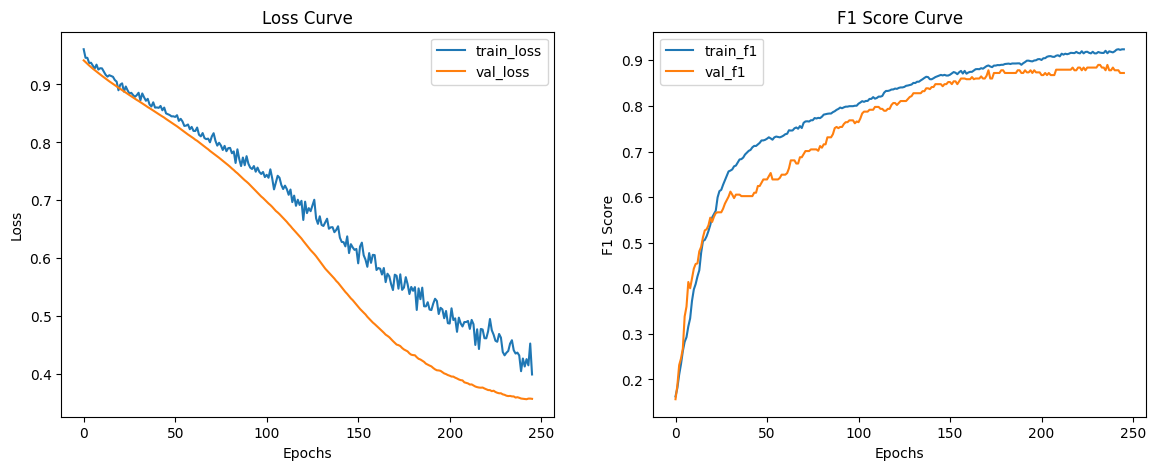

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0     0.8468    0.9400    0.8910       100
           1     0.9326    0.8300    0.8783       100

    accuracy                         0.8850       200
   macro avg     0.8897    0.8850    0.8847       200
weighted avg     0.8897    0.8850    0.8847       200



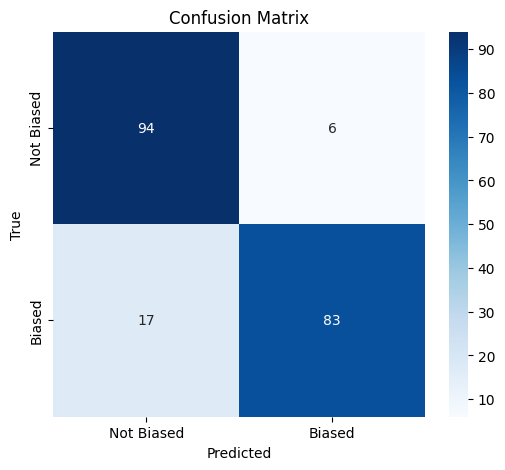

In [ ]:
# ===== 0. Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import requests, zipfile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# ===== 1. Download GloVe 100d =====
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    print("Downloading GloVe embeddings (~822MB zip)...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url, stream=True)
    with open("glove.6B.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Extracting GloVe...")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    print("GloVe ready!")

# ===== 2. Load dataset =====
data = pd.read_csv("balanced_dataset.csv")  # ensure this file exists in Colab
labels = data['isBiased'].values.astype(int).reshape(-1,1)

# ===== 3. Preprocessing =====
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

texts = [clean_text(t) for t in data['title'].astype(str)]

# ===== 4. Tokenization =====
max_words = 2000
max_len = 30
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# ===== 5. Train/Validation Split =====
X_train, X_val, y_train, y_val = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# ===== 6. Load GloVe Embeddings =====
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
covered = 0
for word, i in tokenizer.word_index.items():
    if i < max_words:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec
            covered += 1
print(f"Embedding coverage: {covered}/{len(tokenizer.word_index)} = {covered/len(tokenizer.word_index):.2%}")

# ===== 7. F1 Callback =====
class F1Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = (self.model.predict(X_train, verbose=0) > 0.5).astype(int)
        y_val_pred = (self.model.predict(X_val, verbose=0) > 0.5).astype(int)
        self.train_f1s.append(f1_score(y_train, y_train_pred))
        self.val_f1s.append(f1_score(y_val, y_val_pred))
        print(f" — train_f1: {self.train_f1s[-1]:.4f} — val_f1: {self.val_f1s[-1]:.4f}")

f1_callback = F1Metrics()

# ===== 8. LSTM Model =====
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),  # fine-tune embeddings

    Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.3, return_sequences=False)),

    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=2e-5, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# ===== 9. Callbacks =====
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# ✅ Save best model in Google Drive
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_lstm_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ===== 10. Training =====
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, f1_callback, checkpoint],
    verbose=1
)

# ===== 11. Plot Loss & F1 =====
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_callback.train_f1s, label='train_f1')
plt.plot(f1_callback.val_f1s, label='val_f1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# ===== 12. Evaluation =====
y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Biased','Biased'],
            yticklabels=['Not Biased','Biased'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Embedding coverage: 1860/2731 = 68.11%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,000 (781.25 KB)

 Trainable params: 200,000 (781.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4859 - loss: 1.2214 — train_f1: 0.3459 — val_f1: 0.3312

Epoch 1: val_loss improved from inf to 1.20782, saving model to /content/drive/MyDrive/best_lstm_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.4861 - loss: 1.2211 - val_accuracy: 0.4750 - val_loss: 1.2078 - learning_rate: 2.0000e-05
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4719 - loss: 1.2162 — train_f1: 0.3681 — val_f1: 0.3270

Epoch 2: val_loss improved from 1.20782 to 1.20387, saving model to /content/drive/MyDrive/best_lstm_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.4727 - loss: 1.2161 - val_accuracy: 0.4650 - val_loss: 1.2039 - learning_rate: 2.0000e-05
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5072 - loss: 1.2003 — train_f1: 0.3879 — val_f1: 0.3478

Epoch 3: val_loss improved from 1.20387 to 1.20009, saving model to /content/drive/MyDrive/best_lstm_model.keras
25/2

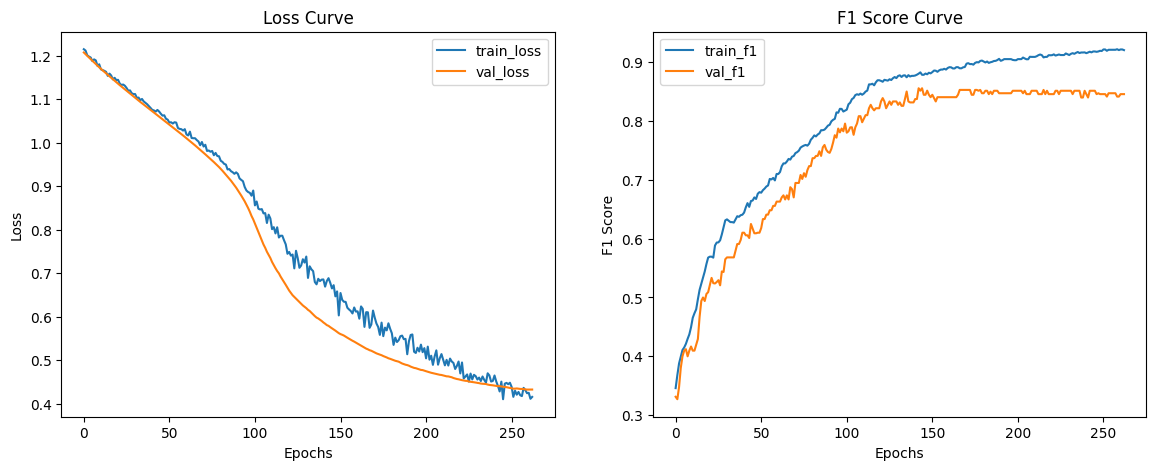

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

           0     0.8469    0.8300    0.8384       100
           1     0.8333    0.8500    0.8416       100

    accuracy                         0.8400       200
   macro avg     0.8401    0.8400    0.8400       200
weighted avg     0.8401    0.8400    0.8400       200



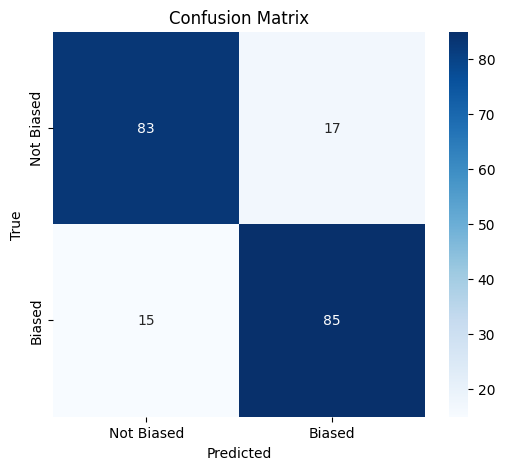

In [ ]:
# ===== 0. Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import requests, zipfile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# ===== 1. Download GloVe 100d =====
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    print("Downloading GloVe embeddings (~822MB zip)...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url, stream=True)
    with open("glove.6B.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Extracting GloVe...")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    print("GloVe ready!")

# ===== 2. Load dataset =====
data = pd.read_csv("balanced_dataset.csv")  # ensure this file exists in Colab
labels = data['isBiased'].values.astype(int).reshape(-1,1)

# ===== 3. Preprocessing =====
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

texts = [clean_text(t) for t in data['title'].astype(str)]

# ===== 4. Tokenization =====
max_words = 2000
max_len = 30
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# ===== 5. Train/Validation Split =====
X_train, X_val, y_train, y_val = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# ===== 6. Load GloVe Embeddings =====
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
covered = 0
for word, i in tokenizer.word_index.items():
    if i < max_words:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec
            covered += 1
print(f"Embedding coverage: {covered}/{len(tokenizer.word_index)} = {covered/len(tokenizer.word_index):.2%}")

# ===== 7. F1 Callback =====
class F1Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = (self.model.predict(X_train, verbose=0) > 0.5).astype(int)
        y_val_pred = (self.model.predict(X_val, verbose=0) > 0.5).astype(int)
        self.train_f1s.append(f1_score(y_train, y_train_pred))
        self.val_f1s.append(f1_score(y_val, y_val_pred))
        print(f" — train_f1: {self.train_f1s[-1]:.4f} — val_f1: {self.val_f1s[-1]:.4f}")

f1_callback = F1Metrics()

# ===== 8. LSTM Model =====
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),  # fine-tune embeddings

    Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.3, return_sequences=False)),

    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=2e-5, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# ===== 9. Callbacks =====
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# ✅ Save best model in Google Drive
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_lstm_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ===== 10. Training =====
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, f1_callback, checkpoint],
    verbose=1
)

# ===== 11. Plot Loss & F1 =====
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_callback.train_f1s, label='train_f1')
plt.plot(f1_callback.val_f1s, label='val_f1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# ===== 12. Evaluation =====
y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Biased','Biased'],
            yticklabels=['Not Biased','Biased'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Extracting GloVe...
GloVe ready!
Embedding coverage: 1860/2731 = 68.11%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,000 (781.25 KB)

 Trainable params: 200,000 (781.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4952 - loss: 0.9531 — train_f1: 0.3710 — val_f1: 0.2968

Epoch 1: val_loss improved from inf to 0.94279, saving model to /content/drive/MyDrive/best_lstm_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.4956 - loss: 0.9530 - val_accuracy: 0.4550 - val_loss: 0.9428 - learning_rate: 2.0000e-05
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5189 - loss: 0.9629 — train_f1: 0.3713 — val_f1: 0.2968

Epoch 2: val_loss improved from 0.94279 to 0.93997, saving model to /content/drive/MyDrive/best_lstm_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.5190 - loss: 0.9627 - val_accuracy: 0.4550 - val_loss: 0.9400 - learning_rate: 2.0000e-05
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5300 - loss: 0.9424 — train_f1: 0.3791 — val_f1: 0.2968

Epoch 3: val_loss improved from 0.93997 to 0.93724, saving model to /content/drive/MyDrive/best_lstm_model.keras
50/

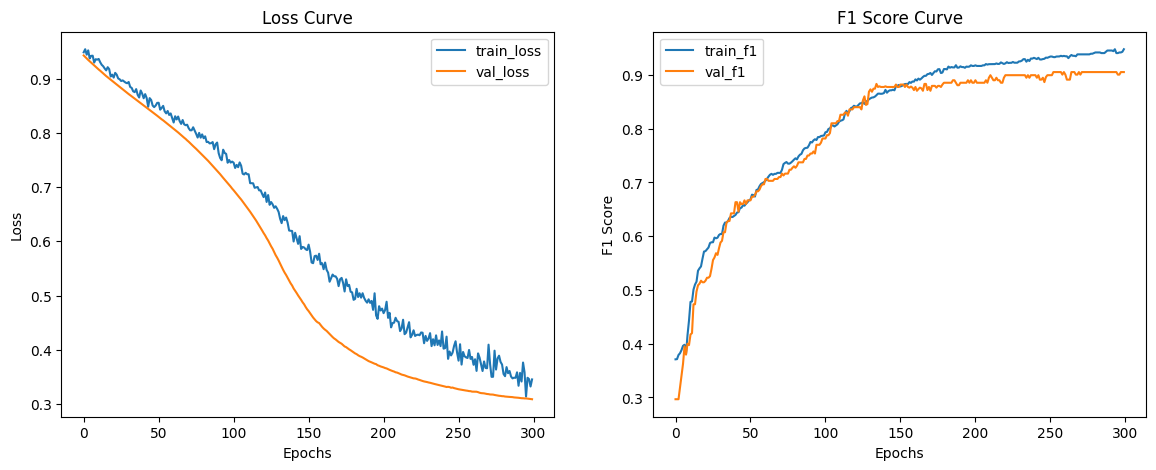

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
              precision    recall  f1-score   support

           0     0.8727    0.9600    0.9143       100
           1     0.9556    0.8600    0.9053       100

    accuracy                         0.9100       200
   macro avg     0.9141    0.9100    0.9098       200
weighted avg     0.9141    0.9100    0.9098       200



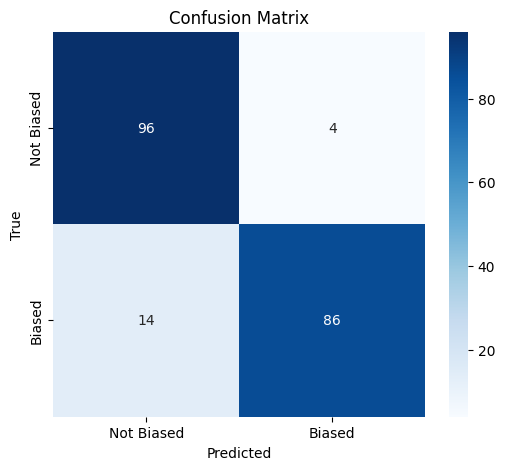

In [ ]:
# ===== 0. Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import requests, zipfile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# ===== 1. Download GloVe 100d =====
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    print("Downloading GloVe embeddings (~822MB zip)...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url, stream=True)
    with open("glove.6B.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Extracting GloVe...")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    print("GloVe ready!")

# ===== 2. Load dataset =====
data = pd.read_csv("balanced_dataset.csv")  # ensure this file exists in Colab
labels = data['isBiased'].values.astype(int).reshape(-1,1)

# ===== 3. Preprocessing =====
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

texts = [clean_text(t) for t in data['title'].astype(str)]

# ===== 4. Tokenization =====
max_words = 2000
max_len = 30
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# ===== 5. Train/Validation Split =====
X_train, X_val, y_train, y_val = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# ===== 6. Load GloVe Embeddings =====
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
covered = 0
for word, i in tokenizer.word_index.items():
    if i < max_words:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec
            covered += 1
print(f"Embedding coverage: {covered}/{len(tokenizer.word_index)} = {covered/len(tokenizer.word_index):.2%}")

# ===== 7. F1 Callback =====
class F1Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = (self.model.predict(X_train, verbose=0) > 0.5).astype(int)
        y_val_pred = (self.model.predict(X_val, verbose=0) > 0.5).astype(int)
        self.train_f1s.append(f1_score(y_train, y_train_pred))
        self.val_f1s.append(f1_score(y_val, y_val_pred))
        print(f" — train_f1: {self.train_f1s[-1]:.4f} — val_f1: {self.val_f1s[-1]:.4f}")

f1_callback = F1Metrics()

# ===== 8. LSTM Model =====
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),  # fine-tune embeddings

    Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.3, return_sequences=False)),

    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=2e-5, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# ===== 9. Callbacks =====
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# ✅ Save best model in Google Drive
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_lstm_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ===== 10. Training =====
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, f1_callback, checkpoint],
    verbose=1
)

# ===== 11. Plot Loss & F1 =====
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_callback.train_f1s, label='train_f1')
plt.plot(f1_callback.val_f1s, label='val_f1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# ===== 12. Evaluation =====
y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Biased','Biased'],
            yticklabels=['Not Biased','Biased'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
